<a href="https://colab.research.google.com/github/ReidelVichot/DEFreightProfiles/blob/main/Roads_Tracks_infograph%2010-10-24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting the Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

!pip install contextily
import contextily as cx

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 38.6 MB/s eta 0:00:00


#Freight Corridor Infograph

In [2]:
dir = "/content/drive/MyDrive/FreightProfiles/"

# Import CCD from google drive Source: Census
ccd_name = "tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd =  gpd.read_file(dir + ccd_name)
ccd = ccd.to_crs("EPSG:2235")
# Import tracks from google drive
# Source: Fist Maps
# https://de-firstmap-delaware.hub.arcgis.com/datasets/railroad-rail-lines/explore?location=39.655622%2C-75.765561%2C13.56
rail_name = "Delaware_Multimodal_2.0_tracks/Delaware_Multimodal_2.0.shp"
rail = gpd.read_file(dir + rail_name)
rail = rail.to_crs("EPSG:2235")
cols = ['NAME','geometry']
ccd = ccd[cols]
cols = ['TRACK_TYPE', 'STATUS', 'LINE_ID', 'OWNER', 'geometry']
rail = rail[cols]

taz_name = "/content/drive/MyDrive/temp_dstep23/TAZ_analysis/DE_TAZ_2021_TRKGEN_region.shp"
taz = gpd.read_file(taz_name)
taz = taz.to_crs("EPSG:2235")

taz["FIS"] = taz['NATRES_20'] + taz['CONS_20'] + taz['MANU_20'] + taz['TRN_UTL_20'] + taz['WHL_RET_20'] + taz['FOOD_SVC_2']
taz["SIS"] = taz['OT_SVCS_20'] + taz['ED_HEALTH_'] + taz['FINANCE_20'] + taz['PRO_BUS_20'] + taz['LE_HOSP_20'] + taz['INFO_20']
taz["FIS_per"] = taz["FIS"]/taz['TOT_20']*100
taz_grpd = taz.groupby("CCD").sum(numeric_only = True)
taz_grpd["FIS_per"] = taz_grpd["FIS"]/taz_grpd["TOT_20"]*100
taz_grpd["FIS_capita"] = taz_grpd["FIS"]/taz_grpd["POP_20"]
taz_grpd.reset_index(inplace=True)
taz_grpd.at[ 9, "CCD"] = "Lower Christiana"
taz_grpd.at[25, "CCD"] = "Upper Christiana"
taz_grpd.at[12, "CCD"] = "Middletown-Odessa"
taz_grpd.at[20, "CCD"] = "Pike Creek-Central Kirkwood"
ccd = ccd.merge(taz_grpd, left_on="NAME", right_on="CCD")

CFC = gpd.read_file(dir + "Delaware_Freight_Corridors_-_FAST_Act_Critical_2.0 (1)/Delaware_Freight_Corridors_-_FAST_Act_Critical_2.0.shp")
CFC = CFC.to_crs("EPSG:2235")

#Freight Movement Bottlenecks
FMB = gpd.read_file(dir + "FreightMovementBottlenecks/Delaware_Multimodal_2.0.shp")
FMB = FMB.to_crs("EPSG:2235")

CoastalCorridor = gpd.read_file(dir + "CoastalCorridor/Delaware_Multimodal_2.0.shp")
CoastalCorridor = CoastalCorridor.to_crs("EPSG:2235")

MetroCorridor = gpd.read_file(dir + "MetroCorridor/Delaware_Multimodal_2.0.shp")
MetroCorridor = MetroCorridor.to_crs("EPSG:2235")

LewesCorridor = gpd.read_file(dir + "LewesCorridor/Delaware_Multimodal_2.0.shp")
LewesCorridor = LewesCorridor.to_crs("EPSG:2235")

BayCorridor = gpd.read_file(dir + "BayCorridor/Delaware_Multimodal_2.0.shp")
BayCorridor = BayCorridor.to_crs("EPSG:2235")

PiedmontCorridor = gpd.read_file(dir + "PiedmontCorridor/Delaware_Multimodal_2.0.shp")
PiedmontCorridor = PiedmontCorridor.to_crs("EPSG:2235")

land = gpd.read_file("/content/drive/MyDrive/FreightProfiles/2022_Land_Use_Land_Cover (1)/2022_Land_Use_Land_Cover.shp")
land = land.to_crs("EPSG:2235")
cols = ["LULC_CATEG", "geometry"]
land = land[cols]
land = land[land.LULC_CATEG == "Cropland"]
land_ccd = gpd.overlay(land, ccd, how="intersection")[["NAME", "LULC_CATEG", "geometry"]]
land_ccd["AgLand_acres"] = land_ccd.area*2.29568e-5
ag_land = land_ccd.groupby("NAME").sum(numeric_only=True).reset_index()

ccd = ccd.merge(ag_land, on="NAME", how="left")

In [3]:
truck_traffic = pd.read_csv(dir + "StreetLight/1669875_All_CCDsAvailable_trucks_2020/1669875_All_CCDsAvailable_trucks_2020/1669875_All_CCDsAvailable_trucks_2020_odg_comm.csv")
cols = ['Vehicle Weight', 'Origin Zone ID', 'Origin Zone Name',
        'Origin Zone Source', 'Destination Zone ID', 'Destination Zone Name',
        'Destination Zone Source', 'Day Type', 'Day Part',
        'Average Daily O-D Traffic (StL Index)',
        'Average Daily Origin Zone Traffic (StL Index)',
       'Average Daily Destination Zone Traffic (StL Index)',
       'Avg Travel Time (sec)']
truck_traffic = truck_traffic[cols]
truck_traffic2 = truck_traffic[truck_traffic["Day Type"]=="0: All Days (M-Su)"][truck_traffic['Day Part']=="00: All Day (12am-12am)"].groupby("Destination Zone Name").sum(numeric_only=True).reset_index()
truck_traffic_ccd = truck_traffic2[truck_traffic2["Destination Zone Name"].isin(ccd["NAME"].values)][['Destination Zone Name', 'Average Daily O-D Traffic (StL Index)']]
ccd  = ccd.merge(truck_traffic_ccd, left_on="CCD", right_on="Destination Zone Name", how="left")
ccd["z-score"] = (ccd["Average Daily O-D Traffic (StL Index)"] - ccd["Average Daily O-D Traffic (StL Index)"].mean())/ccd["Average Daily O-D Traffic (StL Index)"].std()

<ipython-input-3-00d5e9eaa0f9>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  truck_traffic2 = truck_traffic[truck_traffic["Day Type"]=="0: All Days (M-Su)"][truck_traffic['Day Part']=="00: All Day (12am-12am)"].groupby("Destination Zone Name").sum(numeric_only=True).reset_index()


In [4]:
# Original
#CCD = "Dover"
#resol = 85000
#x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
#x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
#y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol
#y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol

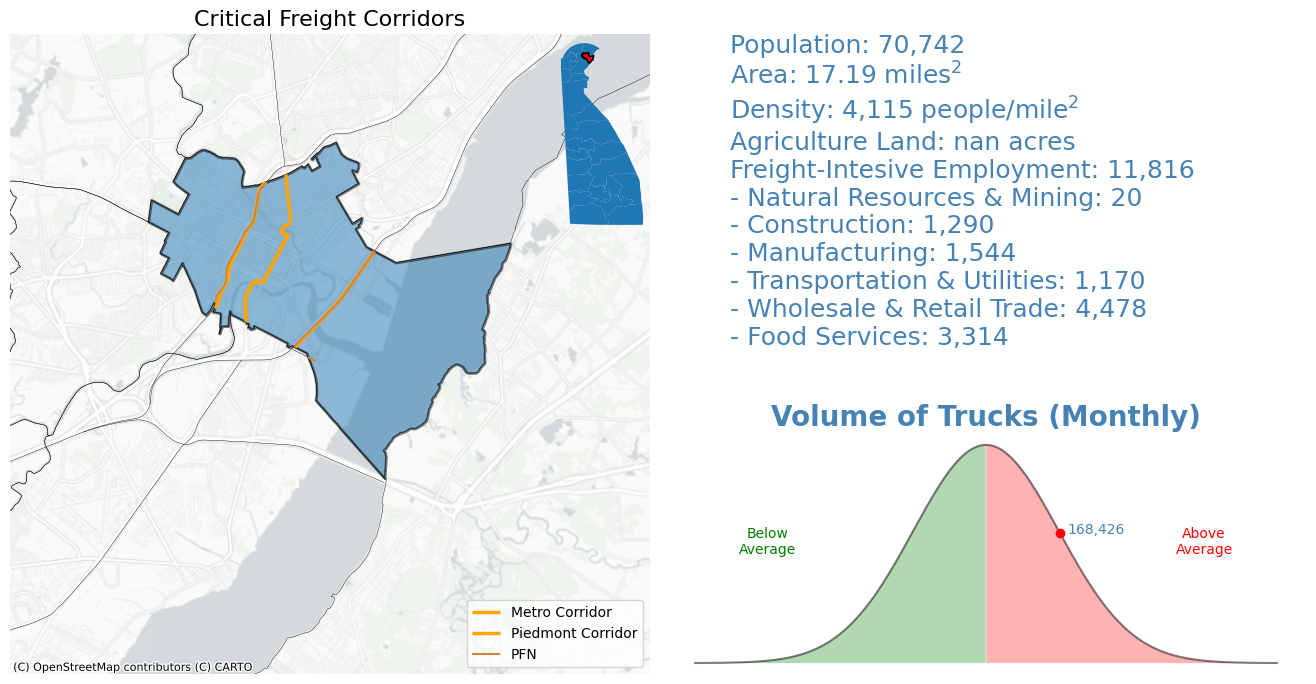

In [5]:
import warnings
# Ignore specific warning
warnings.filterwarnings("ignore", message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.")
# Ignore specific warning
warnings.filterwarnings("ignore", message="Only specify one of 'column' or 'color'. Using 'color'.")


CCD = "Wilmington"
resol = 30000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol  - 6000
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol - 6000



font = {'color':  'black',
        'weight': 'normal',
        'size': 16}
# [left, bottom, width, height]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_axes([0.05, 0.05, 0.4, 0.8])

plt.title("Critical Freight Corridors", fontdict=font)
ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]==CCD].plot(alpha=0.5, edgecolor="k", lw = 2 , ax=ax)
CFC.plot(color="k", linestyle="-", lw = 0.3, ax=ax)
metro_intercept = gpd.overlay(MetroCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
metro_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Metro Corridor', color="orange",
                             zorder=1);
piedmont_intercept = gpd.overlay(PiedmontCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
piedmont_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Piedmont Corridor', color="orange",
                             zorder=1);
bay_intercept = gpd.overlay(BayCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
bay_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Bay Corridor', color="orange",
                             zorder=1);
lewes_intercept = gpd.overlay(LewesCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
lewes_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Lewes Corridor', color="orange",
                             zorder=1);
coastal_intercept = gpd.overlay(CoastalCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
coastal_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Coastal Corridor', color="wheat",
                             zorder=1);
intersept = gpd.overlay(CFC, ccd[ccd["NAME"]==CCD], how="intersection")

intersept[intersept["FREIGHT_NE"]=='CUFC'].plot(linestyle="-", ax=ax,
                             label = 'CUFC', color="steelblue");
intersept[intersept["FREIGHT_NE"]== 'CRFC'].plot(linestyle="-", ax=ax,
                             label = 'CRFC', color="darkgreen");
intersept[intersept["FREIGHT_NE"]== 'PFN'].plot(linestyle="-", ax=ax,
                             label = 'PFN', color="peru");
bottleneck_intersect = gpd.overlay(FMB, ccd[ccd["NAME"]==CCD], how="intersection")
bottleneck_intersect.plot("ROADNAME", linestyle="-", ax=ax,
                             label = "Bottleneck", color="red");

palette = ["orangered", "gold", "olive", "salmon", "tomato", "darksalmon",
           "coral", "indianred", "brown", "firebrick", "maroon"]

ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)
ax.set_axis_off()

ax2 = fig.add_axes([0.37, 0.60, 0.1, 0.25])
ccd.plot(ax=ax2)
ccd[ccd['NAME'] == CCD].plot(ax=ax2, color="r", edgecolor="k", lw = 1)
ax2.set_axis_off()

ax3 = fig.add_axes([0.460, 0.40, 0.4, 0.45])
ax3.set_axis_off()

ax4 = fig.add_axes([0.460, 0.05, 0.4, 0.3])
# prompt: plot a bell curve
# Define the x-axis values
x = np.linspace(-4, 4, 1000)
# Define the y-axis values using the normal distribution function
y = np.exp(-x**2 / 2) / (np.sqrt(2 * np.pi))
# The z-score
z = ccd[ccd["NAME"]==CCD]["z-score"].values[0]

# Create the plot
ax4.plot(x, y, alpha=0.5, color="k")

# Add labels and title
ax4.set_axis_off()
plt.title("Volume of Trucks (Monthly)", color="steelblue", weight="bold", fontsize=20)

# Add a dot on the bell curve at x = 1
ax4.plot(z, np.exp(-z**2 / 2) / (np.sqrt(2 * np.pi)), marker="o", color="red")
if z > 0:
  ax4.text(z+0.1, np.exp(-z**2 / 2) / (np.sqrt(2 * np.pi)), "{:,.0f}".format(ccd[ccd["NAME"]==CCD]["Average Daily O-D Traffic (StL Index)"].values[0]), color="steelblue", ha="left")
else:
  ax4.text(z-0.1, np.exp(-z**2 / 2) / (np.sqrt(2 * np.pi)), "{:,.0f}".format(ccd[ccd["NAME"]==CCD]["Average Daily O-D Traffic (StL Index)"].values[0]), color="steelblue", ha="right")
# Fill the area under the curve with green color
ax4.fill_between(x, y, 0, where=x <= 0, facecolor="green", alpha=0.3)
ax4.fill_between(x, y, 0, where=x > 0, facecolor="red", alpha=0.3)
ax4.text(-3,0.2, "Below\nAverage", color="green", alpha=1, fontsize=10, ha="center")
ax4.text( 3,0.2, "Above\nAverage", color="red", alpha=1, fontsize=10, ha="center")

cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")
ax.legend(loc='lower right')

#header = fig.text(0.5, 0.90, "Freight Profile: " + CCD, fontsize=20, color="k", weight="bold", ha="center")
content =  fig.text(0.5, 0.85,  "Population: " +  "{:,}".format(ccd[ccd["NAME"]==CCD]["POP_20"].values[0]) + "\n" +
                                "Area: " + "{:,.2f}".format(ccd[ccd["NAME"]==CCD].area.values[0]*3.58701e-8) + " miles$^2$\n" +
                                "Density: " + "{:,.0f}".format(ccd[ccd["NAME"]==CCD]["POP_20"].values[0] / ccd[ccd["NAME"]==CCD].area.values[0] / 3.58701e-8) + " people/mile$^2$\n" +
                                "Agriculture Land: " + "{:,.0f} acres".format(ccd[ccd["NAME"]==CCD]['AgLand_acres'].values[0]) + "\n" +
                                "Freight-Intesive Employment: " + "{:,}".format(ccd[ccd["NAME"]==CCD]["FIS"].values[0]) + "\n" +
                                "- Natural Resources & Mining: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['NATRES_20'].values[0]) + "\n" +
                                "- Construction: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['CONS_20'].values[0]) + "\n" +
                                "- Manufacturing: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['MANU_20'].values[0]) + "\n" +
                                "- Transportation & Utilities: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['TRN_UTL_20'].values[0]) + "\n" +
                                "- Wholesale & Retail Trade: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['WHL_RET_20'].values[0]) + "\n"
                                "- Food Services: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['FOOD_SVC_2'].values[0]) + "\n"
                                , color="steelblue", weight="normal", va="top", fontsize=18)
fig.show()

#Truck Parking

,Location,Type,Ave. Stop (Hours),<3 hours,3<8 hours,<8 hours,Peak
3,"First/last-mile roads (Lighthouse Rd, Hay Rd) ...",Last-mile,17.5,34%,10%,56%,Afternoon
8,Christiana Truck Stop and I-495 on/off-ramps f...,Near truck stop,11.1,59%,7%,34%,Morning
23,Wilmington urban area,Urban,3.2,86%,7%,8%,Morning
25,First/last-mile roads near (southwest of) the ...,Last-mile,10.6,50%,11%,39%,"Morning, Afternoon"


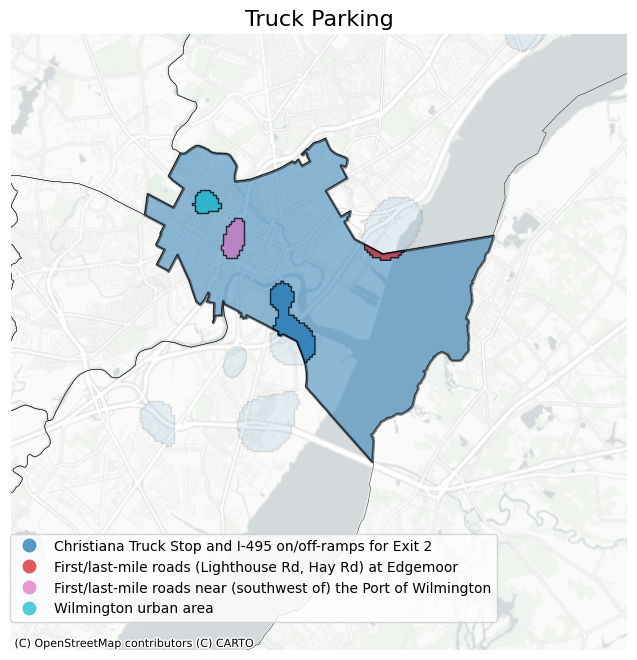

In [23]:
# Load parking data
truck_parking_name =  dir + "DE_Undesig_Clusters_2023_region/DE_Undesig_Clusters_2023_region.shp"
truck_parking =  gpd.read_file(truck_parking_name)
truck_parking = truck_parking.to_crs("EPSG:2235")

# Eliminate innecessary columns
cols = ["Location_", "Type", "Avg_Stop_L", "Under_3",
        "_3_to_8",	"Over_8",	"Peak_Per",	"geometry"]
truck_parking = truck_parking[cols]

# Rename Columns
truck_parking.columns = ["Location", "Type", "Ave. Stop (Hours)",
                         "<3 hours", "3<8 hours", "<8 hours", "Peak",
                         "geometry"]

# Intersect parking with CCD
truck_parking = gpd.overlay(truck_parking, ccd, how="intersection")

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

plt.title("Truck Parking", fontdict=font)
ccd.plot(facecolor = "none", lw = 0.3, ax=ax)

# plot the CCD
ccd[ccd["NAME"]==CCD].plot(alpha=0.5, edgecolor="k", lw = 2 , ax=ax)
# plot parking within the CCD
truck_parking[truck_parking["NAME"]==CCD].plot(column="Location", legend=True,
                                               alpha=0.75, edgecolor="k",
                                               lw = 1 , ax=ax)
# plot all parking
truck_parking.plot(alpha=0.1, edgecolor="k", lw = 1 , ax=ax)

# set axes limits
ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)
ax.set_axis_off()

ax.get_legend().set_bbox_to_anchor((0.8, 0.2))
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")
fig.show()

# Show table
truck_parking[truck_parking["NAME"]==CCD].iloc[:,:-2]

#Rail


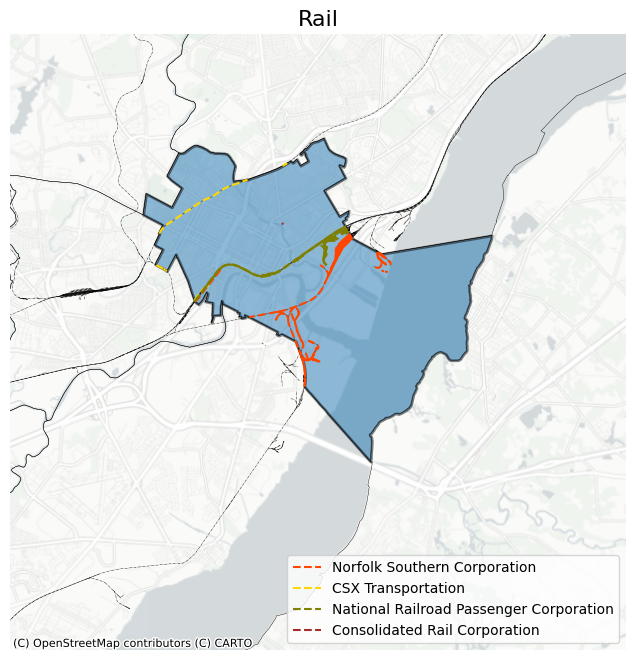

In [31]:
import warnings
# Ignore specific warning
warnings.filterwarnings("ignore", message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.")
# Ignore specific warning
warnings.filterwarnings("ignore", message="Only specify one of 'column' or 'color'. Using 'color'.")


CCD = "Wilmington"
resol = 30000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol  - 6000
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol - 6000

fig, ax = plt.subplots(figsize=(12, 8))

plt.title("Rail", fontdict=font)
ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]==CCD].plot(alpha=0.5, edgecolor="k", lw = 2 , ax=ax)

rail.plot(color="k", linestyle="-.", lw = 0.3, ax=ax)

palette = ["orangered", "gold", "olive", "salmon", "tomato", "darksalmon",
           "coral", "indianred", "brown", "firebrick", "maroon"]

for i in range(len(rail["OWNER"].unique())):
  intersect_rail = gpd.overlay(rail[rail.OWNER==rail["OWNER"].unique()[i]], ccd[ccd["NAME"]==CCD], how="intersection");
  intersect_rail.plot("OWNER", linestyle="--", ax=ax, label = rail["OWNER"].unique()[i], color = palette[i]);

ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)
ax.set_axis_off()

cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")
ax.legend(loc='lower right')

fig.show()

In [33]:
gpd.overlay(rail, ccd, how="intersection")

,TRACK_TYPE,STATUS,LINE_ID,OWNER,NAME,geometry
0,Industry,Active,Delmarva Secondary,Norfolk Southern Corporation,Dover,"LINESTRING (621911.241 415834.465, 621879.679 ..."
1,Industry,Active,Delmarva Secondary,Norfolk Southern Corporation,Dover,"LINESTRING (621516.832 415610.758, 621483.946 ..."
2,Industry,Active,Delmarva Secondary,Norfolk Southern Corporation,Dover,"LINESTRING (619813.748 417190.705, 619771.837 ..."
3,Main,Active,Delmarva Secondary,Norfolk Southern Corporation,Smyrna,"LINESTRING (595823.092 468347.189, 595724.533 ..."
4,Main,Active,Delmarva Secondary,Norfolk Southern Corporation,Dover,"LINESTRING (608681.086 443228.853, 608580.796 ..."
...,...,...,...,...,...,...
1610,Yard,Active,Delmarva Secondary,Norfolk Southern Corporation,Glasgow,"LINESTRING (575889.204 585966.307, 575870.242 ..."
1611,Yard,Active,Delmarva Secondary,Norfolk Southern Corporation,Glasgow,"LINESTRING (574838.529 586053.426, 574790.675 ..."
1612,Siding,Active,Delmarva Secondary,Norfolk Southern Corporation,Glasgow,"LINESTRING (574586.935 586183.638, 574662.988 ..."
1613,Yard,Active,Delmarva Secondary,Norfolk Southern Corporation,Glasgow,"MULTILINESTRING ((575992.265 585718.48, 575929..."


#Land Use

In [8]:
dir = "/content/drive/MyDrive/FreightProfiles/"
# land use file 2022
land_use_22 = gpd.read_file(dir + "2022_Land_Use_Land_Cover (1)/2022_Land_Use_Land_Cover.shp")
land_use_22 = land_use_22.to_crs("EPSG:2235")
# land use file 2017
land_use_17 = gpd.read_file(dir + "2017_Delaware_Landuse_Landcover_Multiple_Years_/Delaware_Landuse_Landcover_Multiple_Years_.shp")
land_use_17 = land_use_17.to_crs("EPSG:2235")
# land use file 2012
land_use_12 = gpd.read_file(dir + "2012_Land_Use_Land_Cover/2012_Land_Use_Land_Cover.shp")
land_use_12 = land_use_12.to_crs("EPSG:2235")
# land use file 2007
land_use_07 = gpd.read_file(dir + "2007_Delaware_Landuse_Landcover_Multiple_Years_/Delaware_Landuse_Landcover_Multiple_Years_.shp")
land_use_07 = land_use_07.to_crs("EPSG:2235")
# select columns of interest
cols = ['LULC_CATEG', 'geometry']
land_use_22 = land_use_22[cols]
land_use_17 = land_use_17[cols]
land_use_12 = land_use_12[cols]
land_use_07 = land_use_07[cols]

# Agricultural-related categories for land_use_22
x1  = land_use_22["LULC_CATEG"] == "Clear-cut"
x2  = land_use_22["LULC_CATEG"] == "Confined Feeding Operations/Feedlots/Holding"
x3  = land_use_22["LULC_CATEG"] == "Cropland"
x4  = land_use_22["LULC_CATEG"] == "Farmsteads and Farm Related Buildings"
x5  = land_use_22["LULC_CATEG"] == "Herbaceous Rangeland"
x6  = land_use_22["LULC_CATEG"] == "Idle Fields"
x7  = land_use_22["LULC_CATEG"] == "Mixed Rangeland"
x8  = land_use_22["LULC_CATEG"] == "Orchards/Nurseries/Horticulture"
x9  = land_use_22["LULC_CATEG"] == "Other Agriculture"
x10 = land_use_22["LULC_CATEG"] == "Pasture"
x11 = land_use_22["LULC_CATEG"] == "Shrub/Brush Rangeland"

land_use_22 = land_use_22[x1|x2|x3|x4|x5|x6|x7|x8|x9|x10|x11]

# Agricultural-related categories for land_use_17
x1  = land_use_17["LULC_CATEG"] == "Clear-cut"
x2  = land_use_17["LULC_CATEG"] == "Confined Feeding Operations/Feedlots/Holding"
x3  = land_use_17["LULC_CATEG"] == "Cropland"
x4  = land_use_17["LULC_CATEG"] == "Farmsteads and Farm Related Buildings"
x5  = land_use_17["LULC_CATEG"] == "Herbaceous Rangeland"
x6  = land_use_17["LULC_CATEG"] == "Idle Fields"
x7  = land_use_17["LULC_CATEG"] == "Mixed Rangeland"
x8  = land_use_17["LULC_CATEG"] == "Orchards/Nurseries/Horticulture"
x9  = land_use_17["LULC_CATEG"] == "Other Agriculture"
x10 = land_use_17["LULC_CATEG"] == "Pasture"
x11 = land_use_17["LULC_CATEG"] == "Shrub/Brush Rangeland"

# Now filter land_use_17 using the correct masks
land_use_17 = land_use_17[x1|x2|x3|x4|x5|x6|x7|x8|x9|x10|x11]

# Agricultural-related categories for land_use_12
x1  = land_use_12["LULC_CATEG"] == "Clear-cut"
x2  = land_use_12["LULC_CATEG"] == "Confined Feeding Operations/Feedlots/Holding"
x3  = land_use_12["LULC_CATEG"] == "Cropland"
x4  = land_use_12["LULC_CATEG"] == "Farmsteads and Farm Related Buildings"
x5  = land_use_12["LULC_CATEG"] == "Herbaceous Rangeland"
x6  = land_use_12["LULC_CATEG"] == "Idle Fields"
x7  = land_use_12["LULC_CATEG"] == "Mixed Rangeland"
x8  = land_use_12["LULC_CATEG"] == "Orchards/Nurseries/Horticulture"
x9  = land_use_12["LULC_CATEG"] == "Other Agriculture"
x10 = land_use_12["LULC_CATEG"] == "Pasture"
x11 = land_use_12["LULC_CATEG"] == "Shrub/Brush Rangeland"

# Now filter land_use_12 using the correct masks
land_use_12 = land_use_12[x1|x2|x3|x4|x5|x6|x7|x8|x9|x10|x11]

# Agricultural-related categories for land_use_07
x1  = land_use_07["LULC_CATEG"] == "Clear-cut"
x2  = land_use_07["LULC_CATEG"] == "Confined Feeding Operations/Feedlots/Holding"
x3  = land_use_07["LULC_CATEG"] == "Cropland"
x4  = land_use_07["LULC_CATEG"] == "Farmsteads and Farm Related Buildings"
x5  = land_use_07["LULC_CATEG"] == "Herbaceous Rangeland"
x6  = land_use_07["LULC_CATEG"] == "Idle Fields"
x7  = land_use_07["LULC_CATEG"] == "Mixed Rangeland"
x8  = land_use_07["LULC_CATEG"] == "Orchards/Nurseries/Horticulture"
x9  = land_use_07["LULC_CATEG"] == "Other Agriculture"
x10 = land_use_07["LULC_CATEG"] == "Pasture"
x11 = land_use_07["LULC_CATEG"] == "Shrub/Brush Rangeland"

# Now filter land_use_07 using the correct masks
land_use_07 = land_use_07[x1|x2|x3|x4|x5|x6|x7|x8|x9|x10|x11]

land_use_22["AgAcres"] = land_use_22.area * 2.295686400367e-5
land_use_17["AgAcres"] = land_use_17.area * 2.295686400367e-5
land_use_12["AgAcres"] = land_use_12.area * 2.295686400367e-5
land_use_07["AgAcres"] = land_use_07.area * 2.295686400367e-5

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
# Import CCD from google drive Source: Census
ccd_name = "tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd =  gpd.read_file(dir + ccd_name)
ccd = ccd.to_crs("EPSG:2235")

land_use_22 = gpd.overlay(land_use_22, ccd[["NAME","geometry"]], how="intersection")
land_use_17 = gpd.overlay(land_use_17, ccd[["NAME","geometry"]], how="intersection")
land_use_12 = gpd.overlay(land_use_12, ccd[["NAME","geometry"]], how="intersection")
land_use_07 = gpd.overlay(land_use_07, ccd[["NAME","geometry"]], how="intersection")

x_22 = land_use_22.groupby(["NAME", "LULC_CATEG"]).sum(numeric_only=True)
x_22.rename(columns={"AgAcres":"2022"}, inplace=True)
x_17 = land_use_17.groupby(["NAME", "LULC_CATEG"]).sum(numeric_only=True)
x_17.rename(columns={"AgAcres":"2017"}, inplace=True)
x_12 = land_use_12.groupby(["NAME", "LULC_CATEG"]).sum(numeric_only=True)
x_12.rename(columns={"AgAcres":"2012"}, inplace=True)
x_07 = land_use_07.groupby(["NAME", "LULC_CATEG"]).sum(numeric_only=True)
x_07.rename(columns={"AgAcres":"2007"}, inplace=True)

land_use = x_22.merge(x_17, on=["NAME","LULC_CATEG"], how="left")
land_use = land_use.merge(x_12, on=["NAME","LULC_CATEG"], how="left")
land_use = land_use.merge(x_07, on=["NAME","LULC_CATEG"], how="left")

In [10]:
land_use.loc["Central Kent"]

,2022,2017,2012,2007
LULC_CATEG,,,,
Confined Feeding Operations/Feedlots/Holding,269.693341,269.693341,177.797893,165.773881
Cropland,23277.615463,23559.091544,24278.218595,27753.550079
Farmsteads and Farm Related Buildings,958.178725,936.814249,1175.498804,1134.576517
Herbaceous Rangeland,362.009770,350.867359,433.565267,605.460934
Idle Fields,225.493593,202.077571,107.904928,258.967149
Mixed Rangeland,325.031081,270.441062,404.875834,204.622978
Orchards/Nurseries/Horticulture,191.706108,195.123680,205.553739,233.644284
Other Agriculture,679.936480,677.457306,492.971529,461.007065
Pasture,472.290568,477.277900,434.142605,421.945803


In [11]:
x_22 = x_22.reset_index()
x_17 = x_17.reset_index()
x_12 = x_12.reset_index()
x_07 = x_07.reset_index()

In [12]:

CCD = "Newark"
resol = 30000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol - 5000
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol - 5000


lu_array = [land_use.loc[CCD]["2007"].sum(), land_use.loc[CCD]["2012"].sum(), land_use.loc[CCD]["2017"].sum(), land_use.loc[CCD]["2022"].sum()]

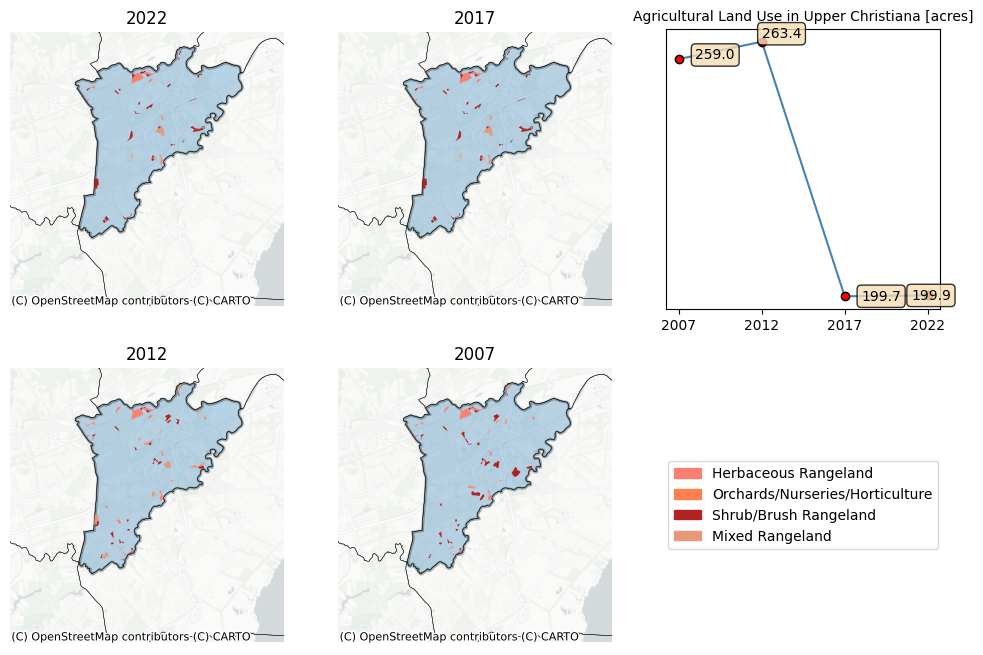

In [13]:
CCD = "Upper Christiana"
resol = 20000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol  - 6000
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol - 6000

lu_array = [land_use.loc[CCD]["2007"].sum(), land_use.loc[CCD]["2012"].sum(), land_use.loc[CCD]["2017"].sum(), land_use.loc[CCD]["2022"].sum()]

import matplotlib.patches as mpatches
import warnings
# Ignore specific warnings
warnings.filterwarnings("ignore", message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.")
warnings.filterwarnings("ignore", message="Only specify one of 'column' or 'color'. Using 'color'.")
warnings.filterwarnings("ignore", message="Boolean Series key will be reindexed to match DataFrame index.")


fig, ax = plt.subplots(2,3, figsize=(12, 8))
axis_i = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
years = [2022, 2017, 2012, 2007]
palette = ["orangered", "maroon", "green", "olive", "salmon", "tomato", "darksalmon",
           "coral", "indianred", "brown", "firebrick"]

patch0 = mpatches.Patch(color=palette[0], label="Clear-cut")
patch1 = mpatches.Patch(color=palette[1], label="Confined Feeding Operations/Feedlots/Holding")
patch2 = mpatches.Patch(color=palette[2], label="Cropland")
patch3 = mpatches.Patch(color=palette[3], label="Farmsteads and Farm Related Buildings")
patch4 = mpatches.Patch(color=palette[4], label="Herbaceous Rangeland")
patch5 = mpatches.Patch(color=palette[5], label="Idle Fields")
patch6 = mpatches.Patch(color=palette[6], label="Mixed Rangeland")
patch7 = mpatches.Patch(color=palette[7], label="Orchards/Nurseries/Horticulture")
patch8 = mpatches.Patch(color=palette[8], label="Other Agriculture")
patch9 = mpatches.Patch(color=palette[9], label="Pasture")
patch10 = mpatches.Patch(color=palette[10], label="Shrub/Brush Rangeland")
patches = []


for i in range(4):
  xx = str(years)[2:]
  axis = axis_i[i]

  axis.set_title(str(years[i]))
  ccd.plot(facecolor = "none", lw = 0.3, ax=axis)
  ccd[ccd["NAME"]==CCD].plot(alpha=0.3, edgecolor="k", lw = 2 , ax=axis)

  xx = str(years[i])[2:]
  x = globals()["land_use_" + xx]

  x[x.NAME == CCD][x.LULC_CATEG == 'Clear-cut'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[0], label = "Clear-cut")
  if not x[x.NAME == CCD][x.LULC_CATEG == 'Clear-cut'].empty:
    patches.append(patch0)
  x[x.NAME == CCD][x.LULC_CATEG == 'Confined Feeding Operations/Feedlots/Holding'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[1], label = "Confined feeding operations")
  if not x[x.NAME == CCD][x.LULC_CATEG == 'Confined Feeding Operations/Feedlots/Holding'].empty:
    patches.append(patch1)
  x[x.NAME == CCD][x.LULC_CATEG == 'Cropland'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[2], label = "Cropland")
  if not x[x.NAME == CCD][x.LULC_CATEG == 'Cropland'].empty:
    patches.append(patch2)
  x[x.NAME == CCD][x.LULC_CATEG == 'Farmsteads and Farm Related Buildings'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[3], label="Farm-related building")
  if not x[x.NAME == CCD][x.LULC_CATEG == 'Farmsteads and Farm Related Buildings'].empty:
    patches.append(patch3)
  x[x.NAME == CCD][x.LULC_CATEG == 'Herbaceous Rangeland'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[4], label="Herbaceus rangeland")
  if not x[x.NAME == CCD][x.LULC_CATEG == 'Herbaceous Rangeland'].empty:
    patches.append(patch4)
  x[x.NAME == CCD][x.LULC_CATEG == 'Idle Fields'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[5], label="Idle fields")
  if not x[x.NAME == CCD][x.LULC_CATEG == 'Idle Fields'].empty:
    patches.append(patch5)
  x[x.NAME == CCD][x.LULC_CATEG == 'Mixed Rangeland'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[6], label="Mixed rangeland")
  if not x[x.NAME == CCD][x.LULC_CATEG == 'Mixed Rangeland'].empty:
    patches.append(patch6)
  x[x.NAME == CCD][x.LULC_CATEG == 'Orchards/Nurseries/Horticulture'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[7], label = "Orchards/Nurseries/Horticulture")
  if not x[x.NAME == CCD][x.LULC_CATEG == 'Orchards/Nurseries/Horticulture'].empty:
    patches.append(patch7)
  x[x.NAME == CCD][x.LULC_CATEG == 'Other Agriculture'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[8], label = "Other agriculture")
  if not x[x.NAME == CCD][x.LULC_CATEG == 'Other Agriculture'].empty:
    patches.append(patch8)
  x[x.NAME == CCD][x.LULC_CATEG == 'Pasture'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[9], label = "Pasture")
  if not x[x.NAME == CCD][x.LULC_CATEG == 'Pasture'].empty:
    patches.append(patch9)
  x[x.NAME == CCD][x.LULC_CATEG == 'Shrub/Brush Rangeland'].plot("LULC_CATEG", lw = 0.3, ax=axis, zorder=3, color=palette[10], label="Shrub/Brush rangeland")
  if not x[x.NAME == CCD][x.LULC_CATEG == 'Shrub/Brush Rangeland'].empty:
    patches.append(patch10)

  axis.set_xlim(x_low, x_high)
  axis.set_ylim(y_low, y_high)
  axis.set_axis_off()

  cx.add_basemap(axis, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

ax[0,2].plot([2007,2012,2017,2022], lu_array, marker="o", c="steelblue", mfc='red', mec='k')

ax[0,2].text(2007 + 1, land_use.loc[CCD]["2007"].sum() + 0, "{:,.1f}".format(land_use.loc[CCD]["2007"].sum()), bbox=props)
ax[0,2].text(2012    , land_use.loc[CCD]["2012"].sum() + 1, "{:,.1f}".format(land_use.loc[CCD]["2012"].sum()), bbox=props)
ax[0,2].text(2017 + 1, land_use.loc[CCD]["2017"].sum() - 1, "{:,.1f}".format(land_use.loc[CCD]["2017"].sum()), bbox=props)
ax[0,2].text(2022 - 1, land_use.loc[CCD]["2022"].sum() - 1, "{:,.1f}".format(land_use.loc[CCD]["2022"].sum()), bbox=props)

ax[0,2].set_yticks([])
ax[0,2].set_title("Agricultural Land Use in " + CCD +" [acres]", fontsize = 10)
ax[0,2].set_xticks([2007,2012,2017,2022])

# Create legend in the second subplot
ax[1,2].legend(handles=set(patches), loc='center')
# Remove axis from the legend subplot
ax[1,2].axis('off')


fig.show()


In [14]:
CCD = "Wilmington"
lu_array = [land_use.loc[CCD]["2007"].sum(), land_use.loc[CCD]["2012"].sum(), land_use.loc[CCD]["2017"].sum(), land_use.loc[CCD]["2022"].sum()]


#Axle Data

In [15]:
axle = gpd.read_file(dir + "Data_Axle_2022_DE_point (1)/Data_Axle_2022_DE_point.shp")
axle = axle.to_crs("EPSG:2235")
# simplify columns
cols = ['company', 'address_li', 'city', 'state',
       'zipcode', 'employee_s', 'employee00',
       'sales_volu', 'sales_vo00', 'square_foo',
       'archive_ve', 'archive_00', 'naics_code',
       'primary_na', 'naics8_des', 'geometry']
axle = axle[cols]

axle['naics_code'] = axle['naics_code'].astype(str)
axle['primary_na'] = axle['primary_na'].astype(str)
# Defining Freight-Intensive sectors as in Holguin-Veras 2023
FIS = ('11','21','22','23','31','32','33','42','44','45','48','49','72')
# Selecting only Freight Intensive Sectors
axle = axle[axle['primary_na'].str.startswith(FIS)]

# Converting to the correct data type
axle.zipcode = axle.zipcode.astype(str)
axle.employee_s	 = axle.employee_s.astype(int)
axle.employee00 = axle.employee00.astype(int)
axle.naics_code = axle.sales_volu.astype(str)
axle.primary_na  = axle.primary_na.astype(str)

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(se

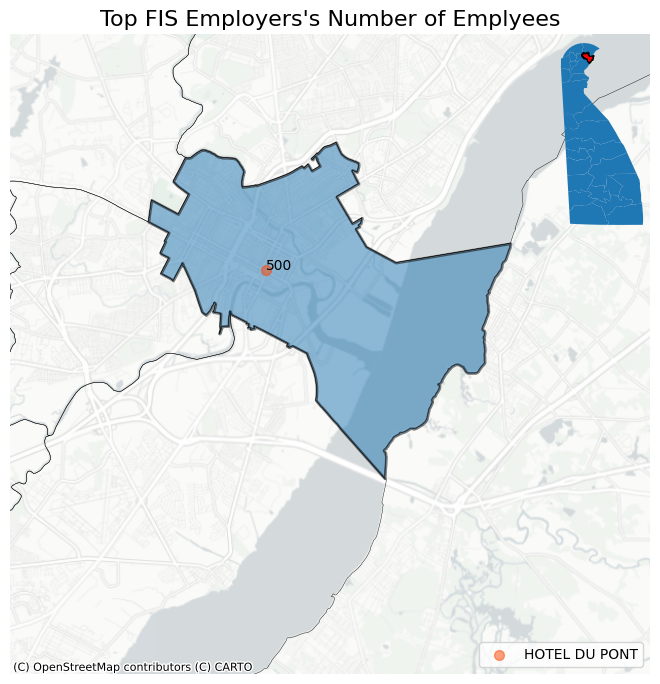

In [16]:
dir = "/content/drive/MyDrive/FreightProfiles/"

# Import CCD from google drive Source: Census
ccd_name = "tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd =  gpd.read_file(dir + ccd_name)
ccd = ccd.to_crs("EPSG:2235")

cols = ['NAME','geometry']
ccd = ccd[cols]

import warnings
# Ignore specific warning
warnings.filterwarnings("ignore", message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.")
# Ignore specific warning
warnings.filterwarnings("ignore", message="Only specify one of 'column' or 'color'. Using 'color'.")


CCD = "Wilmington"
resol = 30000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol  - 6000
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol - 6000


font = {'color':  'black',
        'weight': 'normal',
        'size': 16}
# [left, bottom, width, height]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_axes([0.05, 0.05, 0.4, 0.8])

plt.title("Top FIS Employers's Number of Emplyees", fontdict=font)
ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]==CCD].plot(alpha=0.5, edgecolor="k", lw = 2 , ax=ax)


axle_high_emp = gpd.overlay(axle[axle["employee_s"] >= 300], ccd[ccd["NAME"]==CCD], how="intersection")

palette = ["orangered", "gold", "olive", "salmon", "tomato", "darksalmon",
           "coral", "indianred", "brown", "firebrick", "maroon"]

for i in range(len(axle_high_emp)):
  axle_high_emp.iloc[[i]].geometry.centroid.plot(color=palette[i], alpha= 0.5, markersize=axle_high_emp["employee_s"][i]/10, ax=ax, label=axle_high_emp.company[i], zorder=1)
  if (i == 0)&(CCD=="Brandywine"):

    ax.text(axle_high_emp.iloc[[i]].geometry.centroid.x + 40 , axle_high_emp.iloc[[i]].geometry.centroid.y - 1000, "{:,}".format(axle_high_emp["employee_s"][i]), ha="left")
  elif (i == 1)&(CCD=="Milford North"):
    ax.text(axle_high_emp.iloc[[i]].geometry.centroid.x + 20 , axle_high_emp.iloc[[i]].geometry.centroid.y - 1600, "{:,}".format(axle_high_emp["employee_s"][i]), ha="left")

  else: ax.text(axle_high_emp.iloc[[i]].geometry.centroid.x + 40 , axle_high_emp.iloc[[i]].geometry.centroid.y, "{:,}".format(axle_high_emp["employee_s"][i]), ha="left")
ax.legend(loc='lower right')



palette = ["orangered", "gold", "olive", "salmon", "tomato", "darksalmon",
           "coral", "indianred", "brown", "firebrick", "maroon"]

ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)
ax.set_axis_off()

ax2 = fig.add_axes([0.37, 0.60, 0.1, 0.25])
ccd.plot(ax=ax2)
ccd[ccd['NAME'] == CCD].plot(ax=ax2, color="r", edgecolor="k", lw = 1)
ax2.set_axis_off()

cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")
ax.legend(loc='lower right')

fig.show()

#Development Permits

In [17]:
fname = "/content/drive/MyDrive/FreightProfiles/DevelopmentPermits/"
permits = gpd.read_file(fname + 'Building_Permints_ExportFeatures.shp').to_crs("EPSG:2235")
applications = gpd.read_file(fname + 'Development_Applications_ExportFeatures.shp').to_crs("EPSG:2235")
cols = ["JURISDICTI", "R_NR",  "R_UNITS", "NR_SF", "P_YEAR", "geometry"]
permits = permits[cols]
applications = applications[cols]

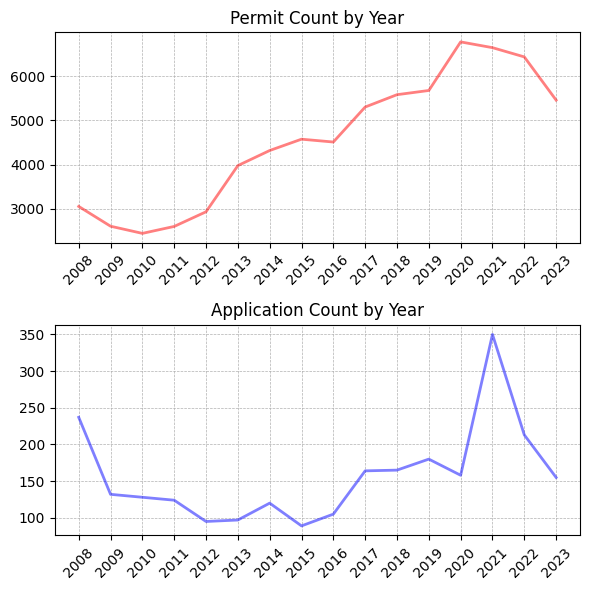

In [18]:
# Grouping the data
a = permits.groupby("P_YEAR").count()
b = applications.groupby("P_YEAR").count()

# Creating the figure and subplots
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# Plotting the data
a["geometry"].plot(ax=ax[0], color='red', alpha=0.5, linewidth=2, label="Permits")
b["geometry"].plot(ax=ax[1], color='blue', alpha=0.5, linewidth=2, label="Applications")

# Setting xticks and xtick labels
xticks = np.arange(0, 16, 1)
xlabels = [f'{x}' for x in np.arange(2008, 2024, 1)]
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xlabels, rotation=45)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xlabels, rotation=45)

# Adding gridlines
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding titles and labels
ax[0].set_title('Permit Count by Year')
ax[1].set_title('Application Count by Year')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].set_xlabel('')
ax[1].set_xlabel('')

# Setting a tight layout to avoid overlap
plt.tight_layout()

# Displaying the plot
plt.show()

In [19]:
permits_ccd = gpd.overlay(permits, ccd[["NAME","geometry"]], how="intersection")
applications_ccd = gpd.overlay(applications, ccd[["NAME","geometry"]], how="intersection")

In [20]:
permits_mod = permits_ccd.groupby(["NAME","P_YEAR"]).sum(numeric_only=True)
permits_mod["count"] = permits_ccd.groupby(["NAME","P_YEAR"])["geometry"].count()
permits_mod.reset_index(inplace=True)

In [21]:
applications_mod = applications_ccd.groupby(["NAME","P_YEAR"]).sum(numeric_only=True)
applications_mod["count"] = applications_ccd.groupby(["NAME","P_YEAR"])["geometry"].count()
applications_mod.reset_index(inplace=True)